In [477]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce
import warnings
import random

pd.options.mode.chained_assignment = None 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [489]:
df = pd.read_csv("survey.csv", dtype='object')
df.drop(['A204_ESP', 'A213_ESP', 'A214_ESP', 'A215_ESP', 'A218_ESP', 'A219_ESP', 'A222_ESP', 'A224_ESP', 
         'A301_ESP', 'A303', 'A309', 'A410_ESP', 'A412_ESP'], inplace=True, axis=1)
df.drop(df.iloc[:, 1:14], inplace=True, axis=1)
df.drop(df.iloc[:, 2:10], inplace = True, axis = 1)
df.drop(df.iloc[:, 5:10], inplace = True, axis = 1)
df.drop(df.iloc[:, 10:25], inplace = True, axis = 1)
df.drop(df.iloc[:, 25:34], inplace = True, axis = 1)
df.drop(df.iloc[:, 40:50], inplace = True, axis = 1)
df.drop(df.iloc[:, 42:49], inplace = True, axis = 1)
df.drop(df.iloc[:, 44:122], inplace = True, axis = 1)
df.drop(df.iloc[:, 45:48], inplace = True, axis = 1)
df.drop(df.iloc[:, 49:52], inplace = True, axis = 1)
df.drop(df.iloc[:, 53:64], inplace = True, axis = 1)
df.drop(df.iloc[:, 54:56], inplace = True, axis = 1)
df.drop(df.iloc[:, 55:59], inplace = True, axis = 1)
df.drop(df.iloc[:, 60:806], inplace = True, axis = 1)
df.drop(df.iloc[:, 61:64], inplace = True, axis = 1)
df.drop(df.iloc[:, 63:], inplace = True, axis = 1)
df.drop(['DES_SECCION', 'ENCUESTADOR_ID', 'COORDINADOR_ID', 'SUPERVISOR_ID', 'A101', 'A212', 'A216'], inplace=True, axis=1)

df_num = df[['A205', 'A303_CUANTOS', 'A308_CANT', 'A309_CANT', 'A401A', 'A403', 'SALARIO_PRINCIPAL', 'ESCOLARIDAD']]
df_cat = df.drop(['A205', 'A303_CUANTOS', 'A308_CANT', 'A309_CANT', 'A401A', 'A403', 'SALARIO_PRINCIPAL', 'ESCOLARIDAD'], axis = 1)


In [479]:
# categorical variable imputation

df_cat['A102'].fillna(1, inplace = True)
df_cat['A405'].fillna(6, inplace = True)
df_cat['A409'].fillna(0, inplace = True)
df_cat['A410'].fillna(0, inplace = True)
df_cat['A411'].fillna(0, inplace = True)
df_cat['A412'].fillna(0, inplace = True)
df_cat['A418'].fillna(0, inplace = True)

df_cat = df_cat.applymap(lambda x: str(x - 1))  # convert all to int to later differentiate from num. vars


In [480]:
# numeric variable imputation

df_num['A205'].fillna(0, inplace = True)
df_num['A303_CUANTOS'].fillna(0, inplace = True)
df_num['A308_CANT'].fillna(0, inplace = True)
df_num['A309_CANT'].fillna(0, inplace = True)
df_num['ESCOLARIDAD'].fillna(0, inplace = True)

df_num = df_num.applymap(int, na_action = 'ignore') # convert all to int to later differentiate from cat. vars

In [481]:
# normalizing numeric features

scaler = MinMaxScaler()
df_num = pd.DataFrame(scaler.fit_transform(df_num), index=df_num.index, columns=df_num.columns)

In [482]:
# joining categorical and numeric features

data = pd.concat((df_cat, df_num), axis = 1)
data = pd.concat((data.iloc[:, :12], data.iloc[:, -8:]), axis = 1)
print(len(data.columns))

20


In [483]:
def fabricate(df, prop):        #randomize prop% subset of sample
    df['fabricated'] = 0
    for id in random.sample(df.index.tolist(), int(len(df)*prop)): 
        for feature in df.loc[id].index.tolist()[:-1]:
            if df[feature].dtype == 'float':
                df.loc[id, feature] = random.randint(min(df[feature]), max(df[feature]))    #if numeric
            else:
                df.loc[id, feature] = random.choice(df[feature])    # if categorical
        df.loc[id, 'fabricated'] = 1
    return prop

In [484]:
prop = fabricate(data, 0.05)                    # 5% proportion randomized. Was repeated with 1% and 20%
data.dropna(inplace = True)                     # drop 5 records with missing values   

In [485]:
# frequency encoder for categorical variables

encoder = ce.CountEncoder(cols=data.iloc[:,:-9], normalize = True)  # slicing off last 9 columns to avoid
data.iloc[:,:-9] = encoder.fit_transform(data.iloc[:,:-9])          # encoding numeric features

[[25905  1065]
 [   25  1394]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     26970
           1       0.57      0.98      0.72      1419

    accuracy                           0.96     28389
   macro avg       0.78      0.97      0.85     28389
weighted avg       0.98      0.96      0.97     28389



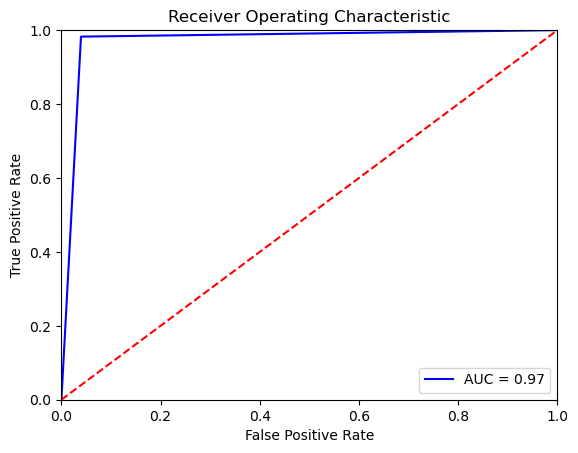

In [493]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, n_init = 10, random_state=4, init_params='random').fit(data.drop('fabricated', axis = 1))
labels = gmm.predict(data.drop('fabricated', axis = 1))
# labels = [1 if i==0 else 0 for i in labels]

print(confusion_matrix(data['fabricated'], labels))

print(classification_report(data['fabricated'], labels))

fpr,tpr, treshold = roc_curve(data['fabricated'], labels)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


[[26764   206]
 [  205  1214]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26970
           1       0.85      0.86      0.86      1419

    accuracy                           0.99     28389
   macro avg       0.92      0.92      0.92     28389
weighted avg       0.99      0.99      0.99     28389



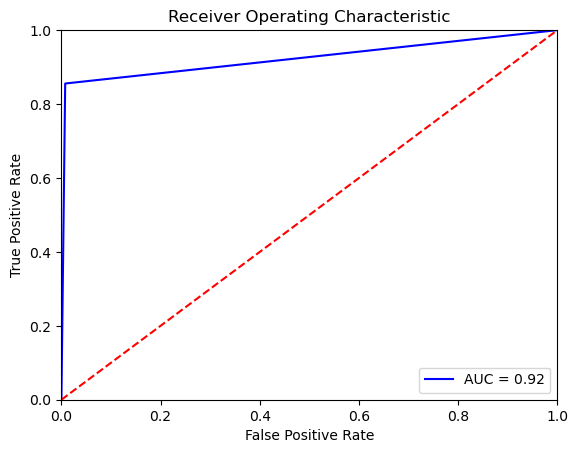

In [487]:
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM(nu=prop, kernel = 'rbf').fit(data.drop('fabricated', axis = 1))
labels = one_class_svm.predict(data.drop('fabricated', axis = 1))
labels = [1 if i==-1 else 0 for i in labels]

print(confusion_matrix(data['fabricated'], labels))

print(classification_report(data['fabricated'], labels))

fpr,tpr, treshold = roc_curve(data['fabricated'], labels)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

c:\Users\ianpv\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


[[26772   198]
 [  197  1222]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26970
           1       0.86      0.86      0.86      1419

    accuracy                           0.99     28389
   macro avg       0.93      0.93      0.93     28389
weighted avg       0.99      0.99      0.99     28389



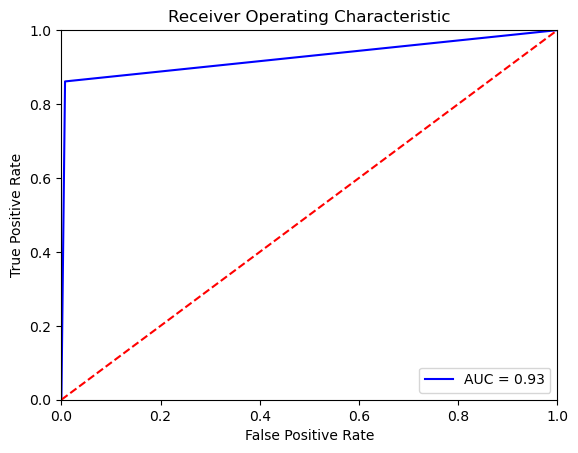

In [488]:
from sklearn.ensemble import IsolationForest
IF = IsolationForest(n_estimators=200,max_samples='auto',contamination=prop, random_state = 4)
IF.fit(data.drop('fabricated', axis = 1))
labels = IF.predict(data.drop('fabricated', axis = 1))
labels = [1 if i==-1 else 0 for i in labels]

print(confusion_matrix(data['fabricated'], labels))

print(classification_report(data['fabricated'], labels))

fpr,tpr, treshold = roc_curve(data['fabricated'], labels)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()